In [41]:
using Rocket, ReactiveMP, GraphPPL, Distributions
using Distributions
using BenchmarkTools, Random
using CairoMakie

In [42]:
@model function smoothing(n, x0, c::ConstVariable, P::ConstVariable)
    
    x_prior ~ NormalMeanVariance(mean(x0), cov(x0)) 

    x = randomvar(n)
    y = datavar(Float64, n)
    
    x_prev = x_prior
    
    for i in 1:n
        x[i] ~ x_prev + c
        y[i] ~ NormalMeanVariance(x[i], P)
        
        x_prev = x[i]
    end

    return x, y
end

smoothing (generic function with 1 method)

In [43]:
seed = 123

rng = MersenneTwister(seed)

P = 100.0

# For large `n` apply: smoothing(..., options = (limit_stack_depth = 500, ))
n = 500

hidden = collect(1:n)
data   = hidden + rand(rng, Normal(0.0, sqrt(P)), n);

In [44]:
function inference(data, x0, P)
    n = length(data)
    
    _, (x, y) = smoothing(n, x0, 1.0, P);

    x_buffer  = buffer(Marginal, n)
    marginals = getmarginals(x)
    
    subscription = subscribe!(marginals, x_buffer)
    
    update!(y, data)
    
    unsubscribe!(subscription)
    
    return getvalues(x_buffer)
end

inference (generic function with 1 method)

In [45]:
x0_prior = NormalMeanVariance(0.0, 10000.0)

NormalMeanVariance{Float64}(μ=0.0, v=10000.0)

In [46]:
@benchmark res = inference($data, $x0_prior, $P)

BenchmarkTools.Trial: 253 samples with 1 evaluation.
 Range (min … max):  15.730 ms … 39.908 ms  ┊ GC (min … max): 0.00% … 55.46%
 Time  (median):     17.433 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   19.760 ms ±  6.343 ms  ┊ GC (mean ± σ):  9.97% ± 15.13%

   ▁▆█▁                                                        
  ▃█████▇▅▆▅▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▄▃▃ ▃
  15.7 ms         Histogram: frequency by time        38.9 ms <

 Memory estimate: 12.55 MiB, allocs estimate: 209093.

In [47]:
@benchmark res = inference($data, $x0_prior, $P)

BenchmarkTools.Trial: 252 samples with 1 evaluation.
 Range (min … max):  15.920 ms … 41.834 ms  ┊ GC (min … max):  0.00% … 53.51%
 Time  (median):     17.524 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   19.856 ms ±  6.416 ms  ┊ GC (mean ± σ):  10.00% ± 15.12%

   ▄▇█▄                                                        
  ▇████▇▅▅▅▄▄▃▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▃▄▃▃▂▂▁▃ ▃
  15.9 ms         Histogram: frequency by time        39.8 ms <

 Memory estimate: 12.55 MiB, allocs estimate: 209093.

In [48]:
results = inference(data, x0_prior, P);

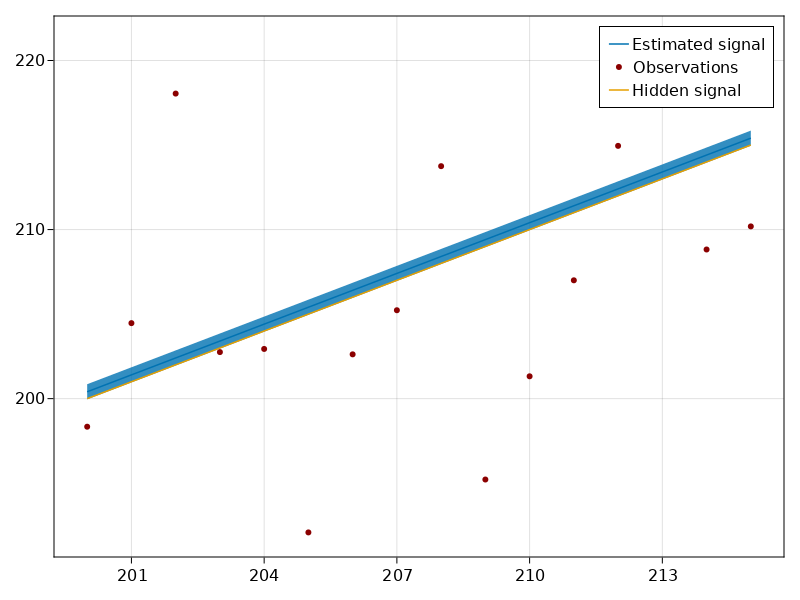

In [49]:
let 
    subrange = 200:215
    
    f  = Figure()
    ax = Axis(f[1, 1])
    
    m = mean.(results)[subrange]
    s = std.(results)[subrange]
    l = m .- s
    u = m .+ s
    
    lines!(ax, subrange, m, label = "Estimated signal")
    band!(ax, subrange, l, u)
    
    scatter!(ax, subrange, data[subrange], markersize = 6, label = "Observations", color = :red4)
    lines!(ax, subrange, hidden[subrange], label = "Hidden signal")
    
    axislegend(ax)
    
    f
end